In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/skeyenet-master/"
%cd gdrive/My\ Drive/skeyenet-master/

Mounted at /content/gdrive/
/content/gdrive/My Drive/skeyenet-master


In [ ]:
ls

Data/    output.png        road_mapper_final.h5
Images/  README.md         Src/
LICENSE  requirements.txt  TO_VINOD_V2_12OCT2020/


## Imports


In [ ]:
import warnings
warnings.filterwarnings('ignore') # ignore any type of warning, can provide category as well.

import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

## Loading Data

In [ ]:
import glob
masks = []
for infile in sorted(glob.glob('./TO_VINOD_V2_12OCT2020/MASKS/*.PNG')):# retrieve file paths matching a specific patter
    print("Current File Being Processed is: " + infile)
    image = cv2.imread (infile)
    image=image/255 # normalize the image
    masks.append (image)
masks=np.array(masks)
print('masks shape:', masks.shape)

Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS0.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS1.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS10.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS100.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS101.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS102.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS103.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS104.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS105.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS106.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS107.PNG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/MASKS/TOF_CHIPS108.PNG
Current File Being Processed is: ./TO_VINOD_V

In [ ]:
import glob
images = []
for infile in sorted(glob.glob('./TO_VINOD_V2_12OCT2020/RASTER/*.JPG')):
    print("Current File Being Processed is: " + infile)
    image = cv2.imread (infile)
    image=image/255
    images.append (image)
images = np.array(images)
print('images shape:', images.shape)

Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS0.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS1.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS10.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS100.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS101.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS102.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS103.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS104.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS105.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS106.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS107.JPG
Current File Being Processed is: ./TO_VINOD_V2_12OCT2020/RASTER/TOF_CHIPS108.JPG
Current File Being Processed is: 

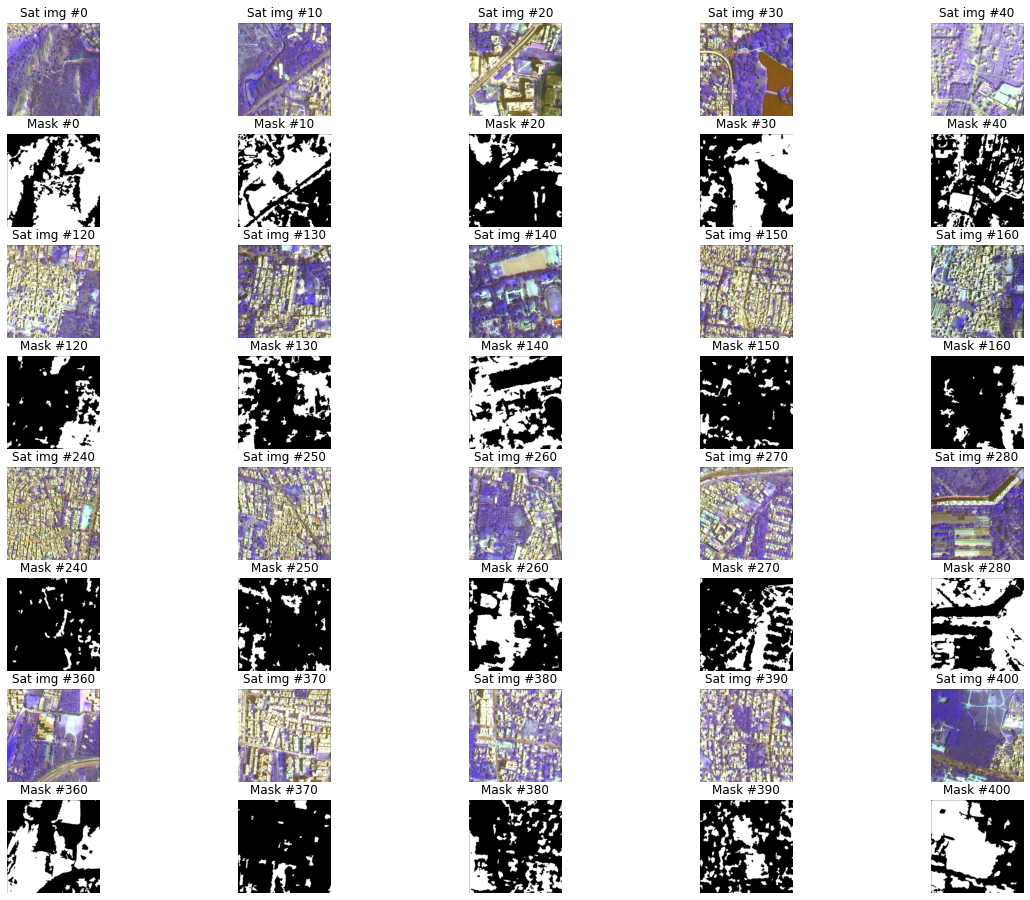

In [ ]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1) 
        # subplot(num rows, num cols, index no. (image no.))
        # the entire plot has 8 rows (y*2=8) and 5 cols (x=5), the third parameter tells which image no. is that. 
        #The parameter keeps incrementing by 1
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

## Metrics


In [ ]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true) # flatten to 1D
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f) # after multiplying the vectors, counts the number of 1s
    # formula = 2*intersection/ [ magnitude(vector1) + magnitude(vector2) ] 
    # magnitude = number of 1s in each vector
    # would have to divide by zero if ytrue and ypred are zero,then intersection also 0, would give 0/0=Nan, so add smooth
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
print(masks.shape)
print(images.shape)

(415, 513, 513, 3)
(415, 513, 513, 3)


In [ ]:
img_rows = 256
img_cols = 256
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, imgs.shape[3]))
    for i in range(imgs.shape[0]):
        imgs_p[i] = cv2.resize(imgs[i], (img_cols, img_rows))
    return imgs_p
masks=preprocess(masks)
print(masks.shape)

(415, 256, 256, 3)


In [ ]:
img_rows = 256
img_cols = 256
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, imgs.shape[3]))
    for i in range(imgs.shape[0]):
        imgs_p[i] = cv2.resize(imgs[i], (img_cols, img_rows))
    return imgs_p
images=preprocess(images)
print(images.shape)

(415, 256, 256, 3)


## Splitting data

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
# random_state is basically used for reproducing your problem the same every time it is run. 
# If you do not use a random_state in train_test_split, 
# every time you make the split you might get a different set of train and test data points 
# and will not help you in debugging in case you get an issue.
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(332, 256, 256, 3)
(332, 256, 256, 3)
TEST SET
(83, 256, 256, 3)
(83, 256, 256, 3)


##Model

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model


In [ ]:
inputs = Input((img_rows, img_cols, 3))

conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
# same padding==results in padding with zeros evenly to the left/right or up/down of the input.
# padding is required when the output and input are supposed to be of same size, since all of the layers here are operating on 
# matrix of same size.
conv1 = BatchNormalization() (conv1)
# conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
# conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
# conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
# conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
# conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4]) #skip connection, concatenate
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
# conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3]) #skip connection, concatenate
conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
# conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2]) #skip connection, concatenate
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
# conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3) #skip connection, concatenate
conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
# conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(3, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

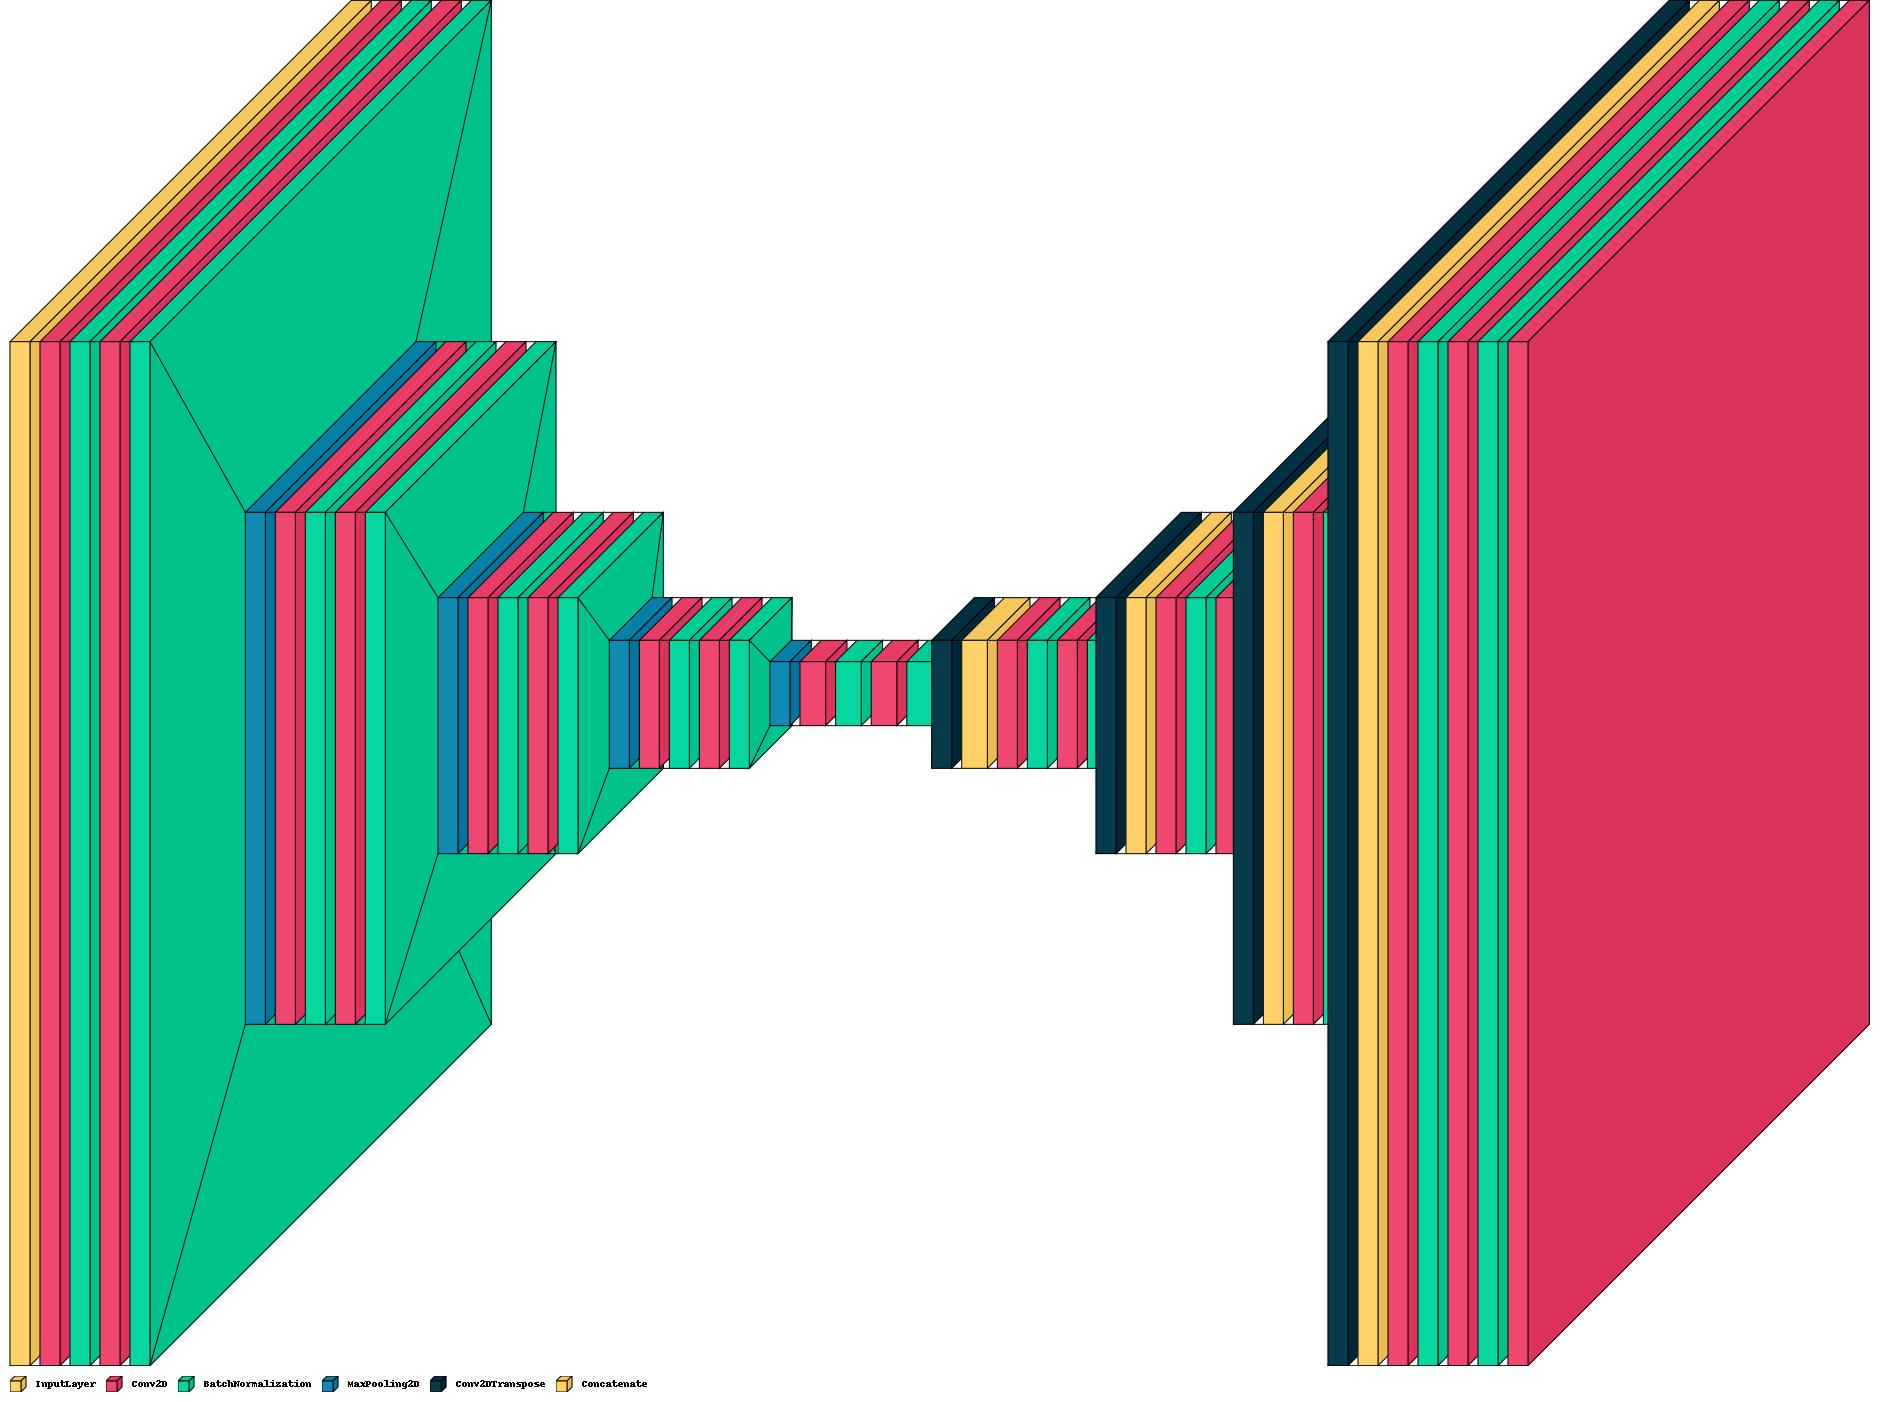

In [ ]:
pip install visualkeras
import visualkeras
# visualkeras.layered_view(model,legend=True, to_file='output.png') # write to disk
visualkeras.layered_view(model,legend=True)

### HYPER_PARAMETERS

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.0001 # was changed to 0.001 later to see more improved results, after it had saturated.
BATCH_SIZE = 8 # number of training examples used in one iteration

### Initializing Callbacks

In [ ]:
pip install TensorboardColab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [ ]:
model_path = "./Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",# choose best model based on this metric
                             mode="min", # the metric chosen should be max or min
                             save_best_only = True,# save the best model, or can save the model after all epochs done
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', #quantity to monitor
                          min_delta = 0, # min change to quantify as no improvement
                          patience = 5, # wait for how many epochs
                          verbose = 1,
                          restore_best_weights = True)

#reduce learning rate when a metric has stopped improving, models benefit from this
lr_reducer = ReduceLROnPlateau(monitor='val_loss',# quantity to monitor
                               factor=0.1,# factor by which reduce
                               patience=4,
                               verbose=1,
                               min_lr=1e-4)

### Compiling the model

In [ ]:
from tensorflow.keras.metrics import Recall, Precision, Accuracy

opt =Adam(LEARNING_RATE) # Adam good for classification tasks.
metrics = [dice_coef, Recall(), Precision(),Accuracy()]
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=metrics)

In [ ]:
history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE
                    )

Epoch 1/100
38/38 [==============================] - 3s 84ms/step - loss: 0.0457 - dice_coef: 0.9545 - recall: 0.9328 - precision: 0.9750 - accuracy: 0.0214 - val_loss: 0.1782 - val_dice_coef: 0.8282 - val_recall: 0.8336 - val_precision: 0.8431 - val_accuracy: 0.0010
Epoch 2/100
38/38 [==============================] - 3s 80ms/step - loss: 0.0488 - dice_coef: 0.9511 - recall: 0.9302 - precision: 0.9727 - accuracy: 0.0232 - val_loss: 0.1814 - val_dice_coef: 0.8254 - val_recall: 0.8312 - val_precision: 0.8380 - val_accuracy: 8.9548e-04
Epoch 3/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0453 - dice_coef: 0.9549 - recall: 0.9333 - precision: 0.9754 - accuracy: 0.0187 - val_loss: 0.1779 - val_dice_coef: 0.8289 - val_recall: 0.8410 - val_precision: 0.8367 - val_accuracy: 0.0013
Epoch 4/100
38/38 [==============================] - 3s 81ms/step - loss: 0.0457 - dice_coef: 0.9543 - recall: 0.9333 - precision: 0.9755 - accuracy: 0.0259 - val_loss: 0.1799 - val_dice_coef:

In [ ]:
model.save("road_mapper_final.h5")

## Testing our Model

### On Test Images

In [ ]:
model = load_model("road_mapper_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss})

In [ ]:
model.evaluate(test_images, test_masks)

3/3 [==============================] - 0s 93ms/step - loss: 0.1508 - dice_coef: 0.8482 - recall: 0.8507 - precision: 0.8604 - accuracy: 0.0764


[0.1507677137851715,
 0.8481804728507996,
 0.8506600260734558,
 0.8604221343994141,
 0.07636980712413788]

In [ ]:
predictions = model.predict(test_images, verbose=1)

3/3 [==============================] - 1s 139ms/step


In [ ]:
thresh_val = 0.2
# predicton_threshold = (predictions > thresh_val).astype(np.uint8) actual
predicton_threshold = np.where((predictions > thresh_val),1,predictions)

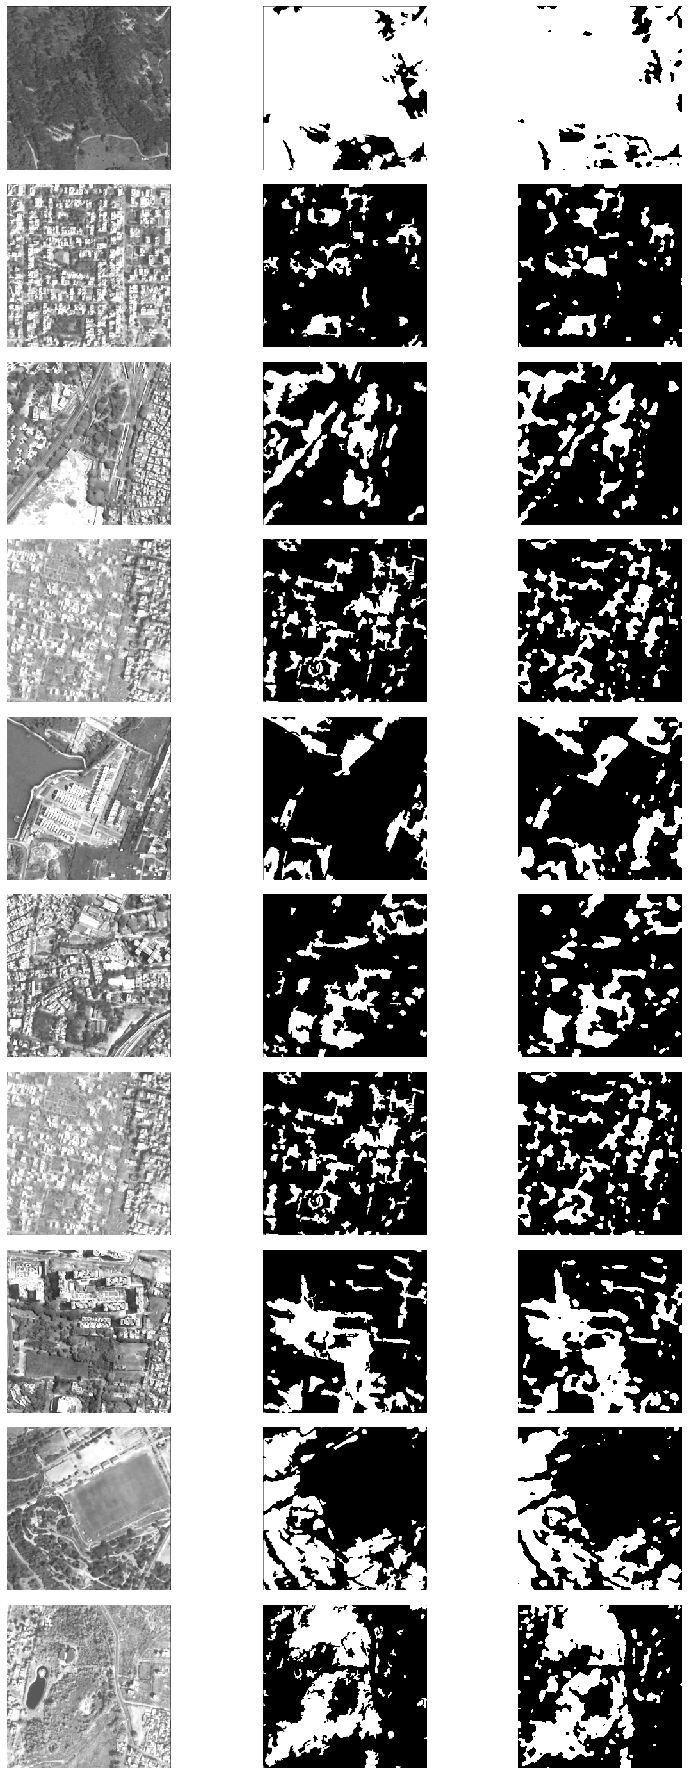

In [ ]:
import matplotlib.gridspec as gridspec
num_samples = 10
f = plt.figure(figsize = (15, 25))
f.subplots_adjust(left=0 )
for i in range(1, num_samples*4, 4):
  
  ix = random.randint(0, len(predictions))
  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  # plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  # plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0])) #remove
  # (thresh, im_bw) = cv2.threshold(predicton_threshold[ix][:,:,0], 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) actual
  imshow(im_bw)
  plt.axis('off')

plt.show()